In [32]:
file_prefix <- "ch19.3"
reuse_fit <- T
source("preset.R")

input_file <- "data/NonhomogVarData.csv"
x_name = "CompanionNumber"
covariate_names <- c("Thorax")

# Common

In [27]:
make_contrast_title <- function(g1, g2) {
    paste(g1, collapse = ".") %+% " vs " %+% paste(g2, collapse = ".")
}
make_group_diff_data <- function(res, g1, g2) {
    g1_mean <- res %>% select(name_to_coef(g1, x_levels, "beta_")) %>% rowMeans()
    g2_mean <- res %>% select(name_to_coef(g2, x_levels, "beta_")) %>% rowMeans()
    tibble(g1 = g1_mean, g2 = g2_mean)
}
plot_post_by_contrast <- function(res, g1, g2, rope = NULL) {
    make_group_diff_data(res, g1, g2) %>% 
        mutate(diff = g1 - g2) %>% 
        plot_post("diff", rope = rope, title = make_contrast_title(g1, g2))
}

contrasts = list( 
  list(g1 = c("D"), g2 = c("A")), 
  list(g1 = c("C"), g2 = c("B"))
)

# prepare data

In [54]:
data <- read_csv(input_file) %>% 
    mutate(Group = factor(Group))

stan_data <- list(
    N = nrow(data), 
    K = n_distinct(data$Group), 
    x = as.integer(data$Group), 
    y = data$Y, 
    S_y = sd(data$Y), 
    M_y = mean(data$Y), 
    SIGMA_ALPHA_PARAMS = unlist(gammaShRaFromModeSD(sd(data$Y) / 2, sd(data$Y) * 2))
)

Parsed with column specification:
cols(
  Group = col_character(),
  Y = col_double()
)



# Same Variance

In [64]:
if (F & reuse_fit) {
    load(save_file_name("fit1"))
} else {
    model <- stan_model(file = "ch19.1.stan")
    fit1 <- sampling(model, data = stan_data, seed = 123, 
                   chains = 4, warmup = 2000, iter = 20000, thin = 4)
    save(model, fit1, file = save_file_name("fit1"))
}

In [65]:
res1 <- fit_to_tibble(fit1)
x_levels <- levels(data$Group)
K <- length(x_levels)
coefs <- map_chr(1:K, ~paste0("beta_", .x))

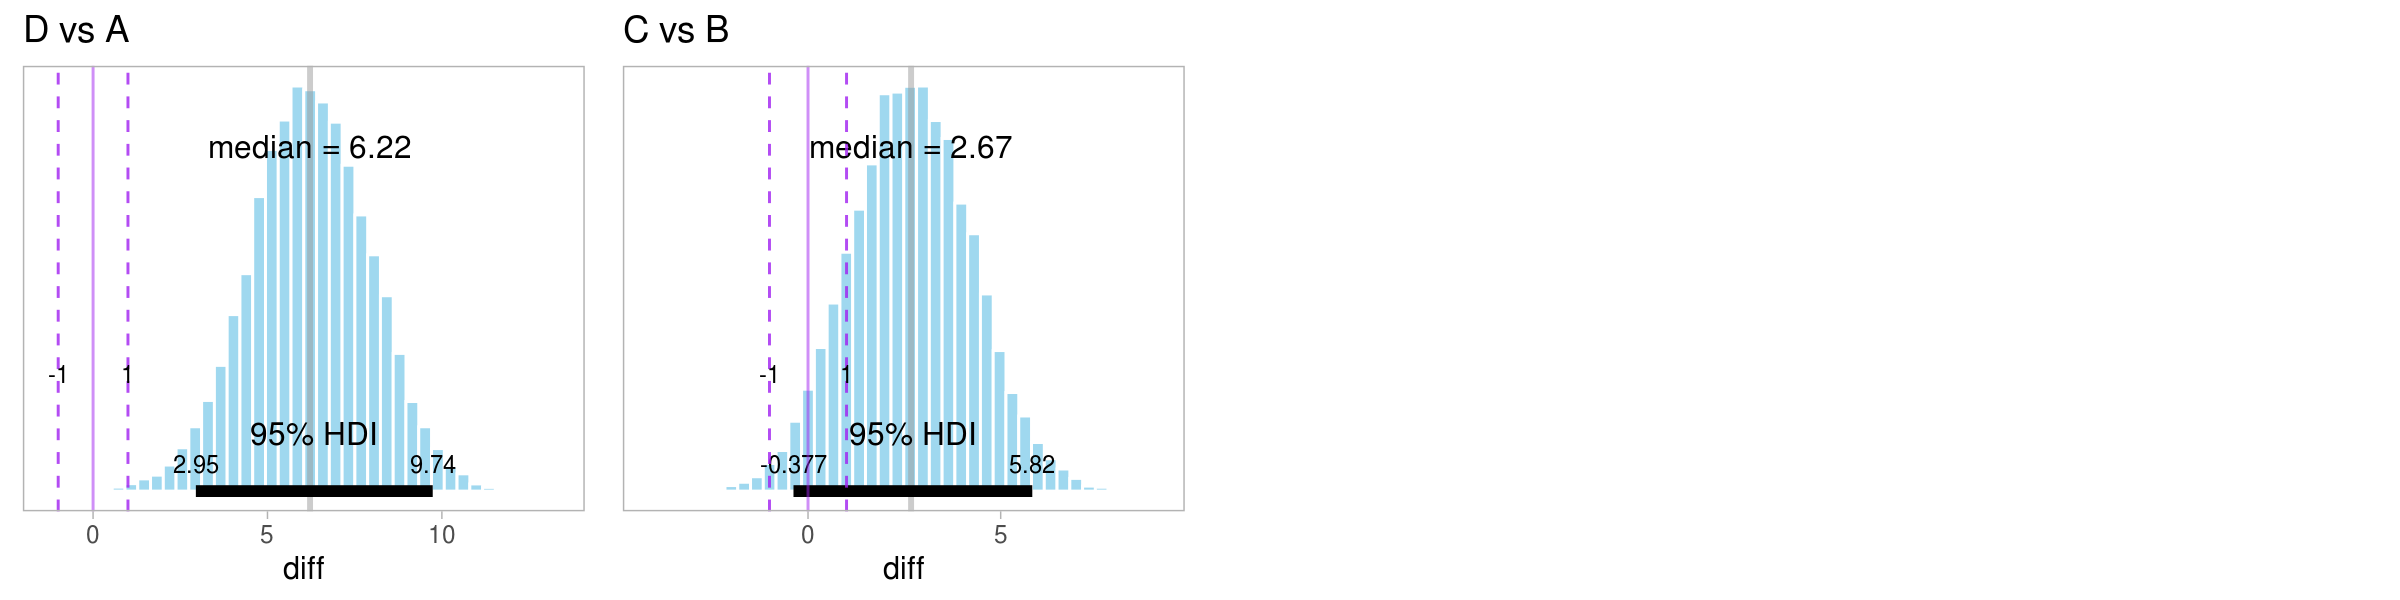

In [68]:
set_plot_size(12, 3)
grid.arrange(
    grobs = c(
        map(contrasts, ~plot_post_by_contrast(res1, .x$g1, .x$g2, rope = c(-1, 1)))
    ), 
    ncol = 4
)

# Diff Variance

In [69]:
if (F & reuse_fit) {
    load(save_file_name("fit"))
} else {
    model <- stan_model(file = "ch19.3.stan")
    fit <- sampling(model, data = stan_data, seed = 123, 
                   chains = 4, warmup = 2000, iter = 20000, thin = 4)
    save(model, fit, file = save_file_name("fit"))
}

Warning message:
“There were 224 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [70]:
res <- fit_to_tibble(fit)
x_levels <- levels(data$Group)
K <- length(x_levels)
coefs <- map_chr(1:K, ~paste0("beta_", .x))
sigmas <- map_chr(1:K, ~paste0("sigma_", .x))

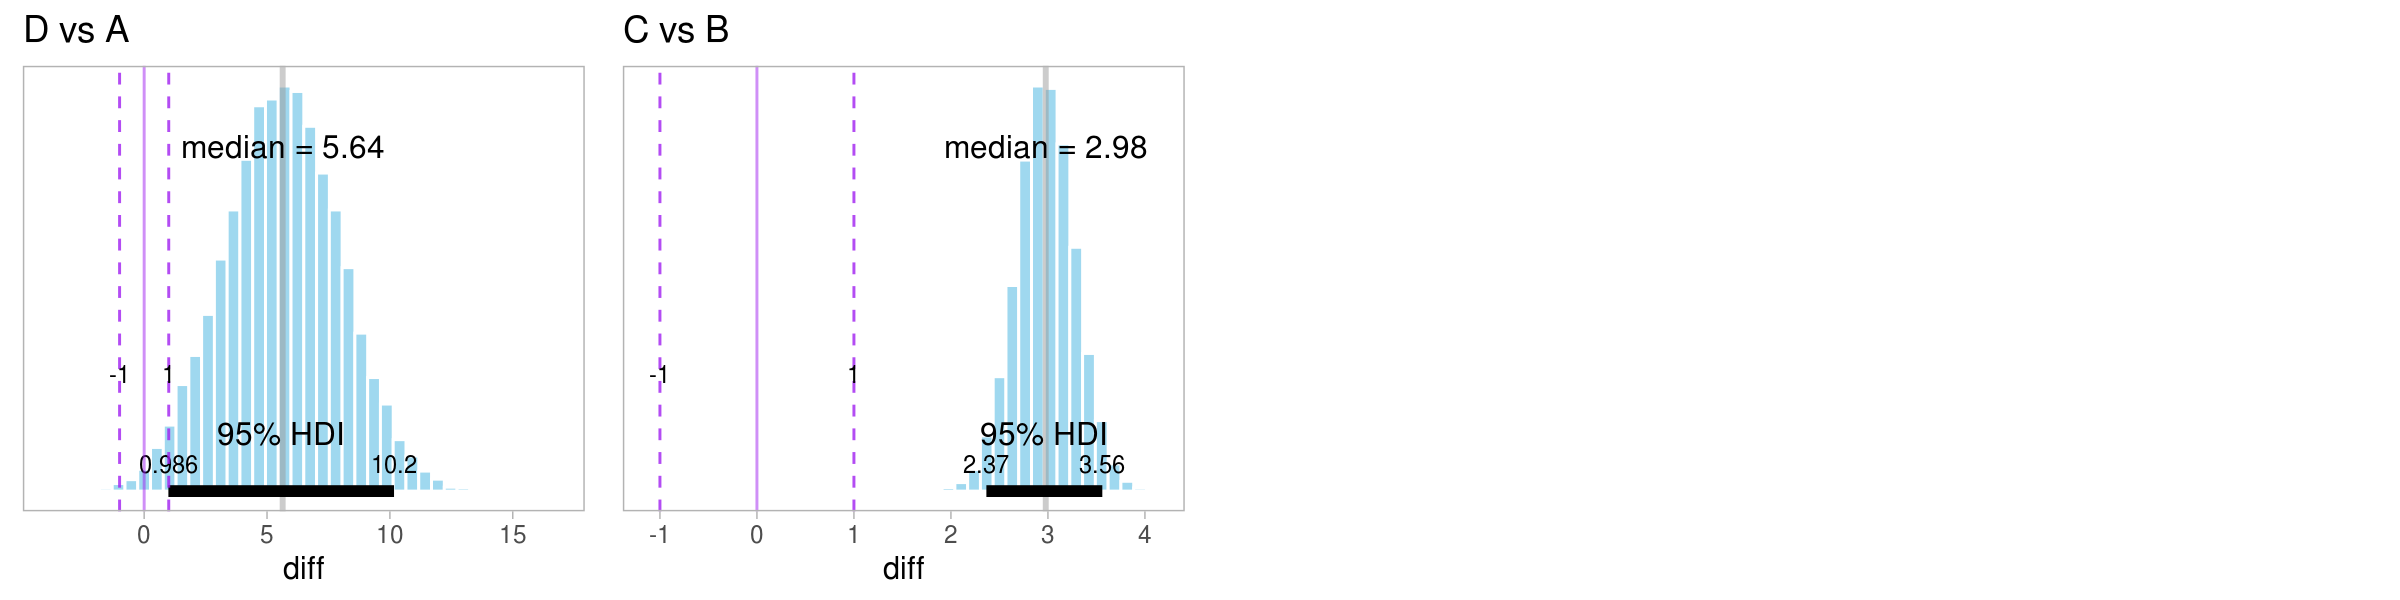

In [72]:
set_plot_size(12, 3)
grid.arrange(
    grobs = c(
        map(contrasts, ~plot_post_by_contrast(res, .x$g1, .x$g2, rope = c(-1.0, 1.0)))
    ), 
    ncol = 4
)